<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C3/blob/main/W1/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Sentiment with Deep Neural Networks

In course 1, you implemented Logistic regression and Naive Bayes for sentiment analysis. However if you were to give your old models an example like:

Your model would have predicted a positive sentiment for that review. However, that sentence has a negative sentiment and indicates that the movie was not good. To solve those kinds of misclassifications, you will write a program that uses deep neural networks to identify sentiment in text. By completing this assignment, you will:

* Understand how you can build/design a model using layers
* Train a model using a training loop
* Use a binary cross-entropy loss function
* Compute the accuracy of your model
* Predict using your own input

As you can tell, this model follows a similar structure to the one you previously implemented in the second course of this specialization.

Indeed most of the deep nets you will be implementing will have a similar structure. The only thing that changes is the model architecture, the inputs, and the outputs. Before starting the assignment, we will introduce you to the Google library trax that we use for building and training models.
Now we will show you how to compute the gradient of a certain function f by just using .grad(f).

Trax source code can be found on Github: Trax
The Trax code also uses the JAX library: JAX

## Part 1: Import libraries and try out Trax

In [3]:
import os 
import random as rnd

# Install trax

!pip install sentencepiece==0.1.91
!pip install trax

# import relevant libraries
import trax
from trax import fastmath

# set random seeds to make this notebook easier to replicate
#trax.supervised.trainer_lib.init_random_number_generators(31)

# import trax.fastmath.numpy
import trax.fastmath.numpy as np

# import trax.layers
from trax import layers as tl

# Download the utils file

!wget https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C3/main/W1/utils.py

# import Layer from the utils.py file
from utils import Layer, load_tweets, process_tweet

print("Imports OK")

--2020-11-24 21:39:52--  https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C3/main/W1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2789 (2.7K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.72K  --.-KB/s    in 0s      

2020-11-24 21:39:52 (17.5 MB/s) - ‘utils.py’ saved [2789/2789]

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Imports OK


### Since I imported trax's version of numpy I can create vectors directly.

In [4]:
a = np.array((5., 2.))

type(a) # Notice it's not a np array but a jax DeviceArray.

jax.interpreters.xla.DeviceArray

In [5]:
# Now do a function with the same array

def f(x):

    return(x**2)

print(f"f(a) = {f(a)}")

f(a) = [25.  4.]


In [6]:
# And now the derivative (2x)

grad_f = trax.fastmath.grad(fun = f) # grad only takes scalar arguments
type(grad_f)

function

In [7]:
# grad_f(a)
b = 13.0
grad_b = grad_f(b)

display(grad_b)

DeviceArray(26., dtype=float32)

# Part 2: Importing the data

## 2.1 Loading in the data
Import the data set.

* You may recognize this from earlier assignments in the specialization.
* Details of process_tweet function are available in utils.py file.

In [8]:
import numpy as np # Let's go back to the usual thing.

In [9]:
all_pos_tweets, all_neg_tweets = load_tweets()

print("Number of positive tweets", len(all_pos_tweets))
print("Number of negative tweets", len(all_neg_tweets))

Number of positive tweets 5000
Number of negative tweets 5000


## Now I'll create train and validation sets

* Shuffle the tweets if they are not randomly sorted.
* Split the positive in train-test (80-20 because I can).
* Add labels (1 positive, 0 negative).
* Check it all.

In [10]:
train_pos = all_pos_tweets[:4000]
test_pos = all_pos_tweets[4000:]

train_neg = all_neg_tweets[:4000]
test_neg = all_neg_tweets[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

print("Length of train_pos:", len(train_pos))
print("Length of train_neg:", len(train_neg))

print("Length of test_pos:", len(test_pos))
print("Length of test_neg:", len(test_neg))

print("Length of train_x:", len(train_x))
print("Length of train_y:", len(train_y))

print("First 5 values of tags", train_y[0:5])
print("Last 5 values of tags", train_y[-5:])



Length of train_pos: 4000
Length of train_neg: 4000
Length of test_pos: 1000
Length of test_neg: 1000
Length of train_x: 8000
Length of train_y: 8000
First 5 values of tags [1. 1. 1. 1. 1.]
Last 5 values of tags [0. 0. 0. 0. 0.]


### Preprocess the tweets to clean them. I have a function but in any case I'm used to this.

In [11]:
# This function only processes one tweet. I'll call it in a loop or a list comprehension

print("The first positive tweet is:", all_pos_tweets[0])

clean_tweet = process_tweet(all_pos_tweets[0])

print("The clean tweet is:", clean_tweet) # Notice it removes all the twitter handles and the "#" symbol. It also tokenizes and stems the words.

The first positive tweet is: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
The clean tweet is: ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


# 2.2 Building the vocabulary
Now build the vocabulary.

* Map each word in each tweet to an integer (an "index").
* The following code does this for you, but please read it and understand what it's doing.
* Note that you will build the vocabulary based on the training data.
* To do so, you will assign an index to everyword by iterating over your training set.
* The vocabulary will also include some special tokens

* <--PAD--> padding
* <--END-->: end of line
* <--UNK-->: a token representing any word that is not in the vocabulary.

In [12]:
# Start with the padding, end and UNK

vocab = {"<PAD>": 0, "<END>": 1, "<UNK>": 2}

# Keep in mind, the vocabulary is only with the training data!!

for tweet in train_x:
    processed_tweet = process_tweet(tweet)

    for word in processed_tweet:
        if word not in vocab:
            vocab[word] = len(vocab) # len vocab changes with every new word

print("Total words:", len(vocab))

#display(vocab)

Total words: 9092


## Exercise 01
Instructions: Write a program tweet_to_tensor that takes in a tweet and converts it to an array of numbers. You can use the Vocab dictionary you just found to help create the tensor.

* Use the vocab_dict parameter and not a global variable.
* Do not hard code the integer value for the __UNK__ token.
* Map each word in tweet to corresponding token in 'Vocab'
* Use Python's Dictionary.get(key,value) so that the function returns a default value if the key is not found in the dictionary.

In [13]:
def tweet_to_tensor(tweet, vocab_dict, unk_token = "<UNK>"):
    """
    Take a tweet (tokens) and return a tensor (numbers) basically, translate from keys to values
    Inputs:
      Tweet: a clean tweet
      vocab_dict: the vocabulary, word and index
    Output:
      tensor_l: a vector (list) with the indices of the words
    """
    word_list = process_tweet(tweet)

    unk_ID = vocab_dict[unk_token]
    tensor_l = []

    for word in word_list:
      if word in vocab_dict:
        word_ID = vocab_dict[word]
        tensor_l.append(word_ID)
      else:
        tensor_l.append(unk_ID)

    return tensor_l



In [14]:
print("Tweet is:", test_pos[0])
tensor_tweet = tweet_to_tensor(test_pos[0], vocab)
print("Corresponding tensor is:", tensor_tweet)

Tweet is: Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan
Corresponding tensor is: [1065, 136, 479, 2351, 745, 8146, 1123, 745, 53, 2, 2672, 791, 2, 2, 349, 601, 2, 3489, 1017, 597, 4559, 9, 1065, 157, 2, 2]


In [15]:
#Thorough checks

# test tweet_to_tensor

def test_tweet_to_tensor():
    test_cases = [
        
        {
            "name":"simple_test_check",
            "input": [test_pos[1], vocab],
            "expected":[444, 2, 304, 567, 56, 9],
            "error":"The function gives bad output for test_pos[1]. Test failed"
        },
        {
            "name":"datatype_check",
            "input":[test_pos[1], vocab],
            "expected":type([]),
            "error":"Datatype mismatch. Need only list not np.array"
        },
        {
            "name":"without_unk_check",
            "input":[test_pos[1], vocab],
            "expected":6,
            "error":"Unk word check not done- Please check if you included mapping for unknown word"
        }
    ]
    count = 0
    for test_case in test_cases:
        
        try:
            if test_case['name'] == "simple_test_check":
                assert test_case["expected"] == tweet_to_tensor(*test_case['input'])
                count += 1
            if test_case['name'] == "datatype_check":
                assert isinstance(tweet_to_tensor(*test_case['input']), test_case["expected"])
                count += 1
            if test_case['name'] == "without_unk_check":
                assert None not in tweet_to_tensor(*test_case['input'])
                count += 1
                
            
            
        except:
            print(test_case['error'])
    if count == 3:
        print("\033[92m All tests passed")
    else:
        print(count," Tests passed out of 3")
test_tweet_to_tensor()


 All tests passed


## 2.4 Creating a batch generator
Most of the time in Natural Language Processing, and AI in general we use batches when training our data sets.

If instead of training with batches of examples, you were to train a model with one example at a time, it would take a very long time to train the model.

* You will now build a data generator that takes in the positive/negative tweets and returns a batch of training examples.
* It returns the model inputs, the targets (positive or negative labels) and the weight for each target (ex: this allows us to can treat some examples as more important to get right than others, but commonly this will all be 1.0).
* Once you create the generator, you could include it in a for loop.

The generator returns the next batch each time it's called.

* This generator returns the data in a format (tensors) that you could directly use in your model.
It returns a triplet: the inputs, targets, and loss weights:
* Inputs is a tensor that contains the batch of tweets we put into the model.
* Targets is the corresponding batch of labels that we train to generate.
* Loss weights here are just 1s with same shape as targets.

Next week, you will use it to mask input padding.

###Exercise 02
Implement data_generator.

In [16]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input: 
        data_pos - Set of posstive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - An array specifying the importance of each example
        
    '''     
### START GIVEN CODE ###
    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
        
    stop = False
    
    # Loop indefinitely
    while not stop:  
        
        # create a batch with positive and negative examples
        batch = []
        
        # First part: Pack n_to_take positive examples
        
        # Start from pos_index and increment i up to n_to_take
        for i in range(n_to_take):
                    
            # If the positive index goes past the positive dataset lenght,
            if pos_index >= len_data_pos: 
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)
                    
            # get the tweet as pos_index
            tweet = data_pos[pos_index_lines[pos_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment pos_index by one
            pos_index = pos_index + 1

### END GIVEN CODE ###
            
### START CODE HERE (Replace instances of 'None' with your code) ###

        # Second part: Pack n_to_take negative examples
    
        # Using the same batch list, start from neg_index and increment i up to n_to_take
        for i in range(n_to_take):
            
            # If the negative index goes past the negative dataset length,
            if neg_index >= len_data_neg:
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                    
                # If user wants to keep re-using the data, reset the index
                neg_index = 0
                
                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
            # get the tweet as pos_index
            tweet = data_neg[neg_index_lines[neg_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment neg_index by one
            neg_index += 1

### END CODE HERE ###         

### START GIVEN CODE ###
        if stop:
            break;

        # Update the start index for positive data 
        # so that it's n_to_take positions after the current pos_index
        pos_index += n_to_take
        
        # Update the start index for negative data 
        # so that it's n_to_take positions after the current neg_index
        neg_index += n_to_take
        
        # Get the max tweet length (the length of the longest tweet) 
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch]) 
        
        
        # Initialize the input_l, which will 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:
### END GIVEN CODE ###

### START CODE HERE (Replace instances of 'None' with your code) ###
            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)
            
            # Generate a list of zeros, with length n_pad
            pad_l = [0]*n_pad
            
            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l
            
            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)
  
        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = [1]*n_to_take
        
        # Generate the list of targets for the negative examples (a list of ones)
        # The length is the number of negative examples in the batch
        target_neg = [0]*n_to_take
        
        # Concatenate the positve and negative targets
        target_l = target_pos + target_neg
        
        # Convert the target list into a numpy array
        targets = np.array(target_l)

        # Example weights: Treat all examples equally importantly.
        example_weights = np.ones_like(targets)
        

### END CODE HERE ###

### GIVEN CODE ###
        # note we use yield and not return
        yield inputs, targets, example_weights

In [17]:
# Test it

rnd.seed(30) 

# Create the training data generator
def train_generator(batch_size, shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, True, vocab, shuffle)

# Create the validation data generator
def val_generator(batch_size, shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, True, vocab, shuffle)

# Create the validation data generator
def test_generator(batch_size, shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, False, vocab, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2005 4451 3201    9    0    0    0    0    0    0    0]
 [4954  567 2000 1454 5174 3499  141 3499  130  459    9]
 [3761  109  136  583 2930 3969    0    0    0    0    0]
 [ 250 3761    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [18]:
# Test the train_generator

# Create a data generator for training data,
# which produces batches of size 4 (for tensors and their respective targets)
tmp_data_gen = train_generator(batch_size = 4)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
print(f"The targets shape is {tmp_targets.shape}")
print(f"The example weights shape is {tmp_example_weights.shape}")

for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 14)
The targets shape is (4,)
The example weights shape is (4,)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5738 2901 3761    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 858  256 3652 5739  307 4458  567 1230 2767  328 1202 3761    0    0]; target 0; example weights 1


## Part 3: Defining classes
In this part, you will write your own library of layers. It will be very similar to the one used in Trax and also in Keras and PyTorch. Writing your own small framework will help you understand how they all work and use them effectively in the future.

## 3.1 ReLU class
You will now implement the ReLU activation function in a class below. The ReLU function looks as follows:

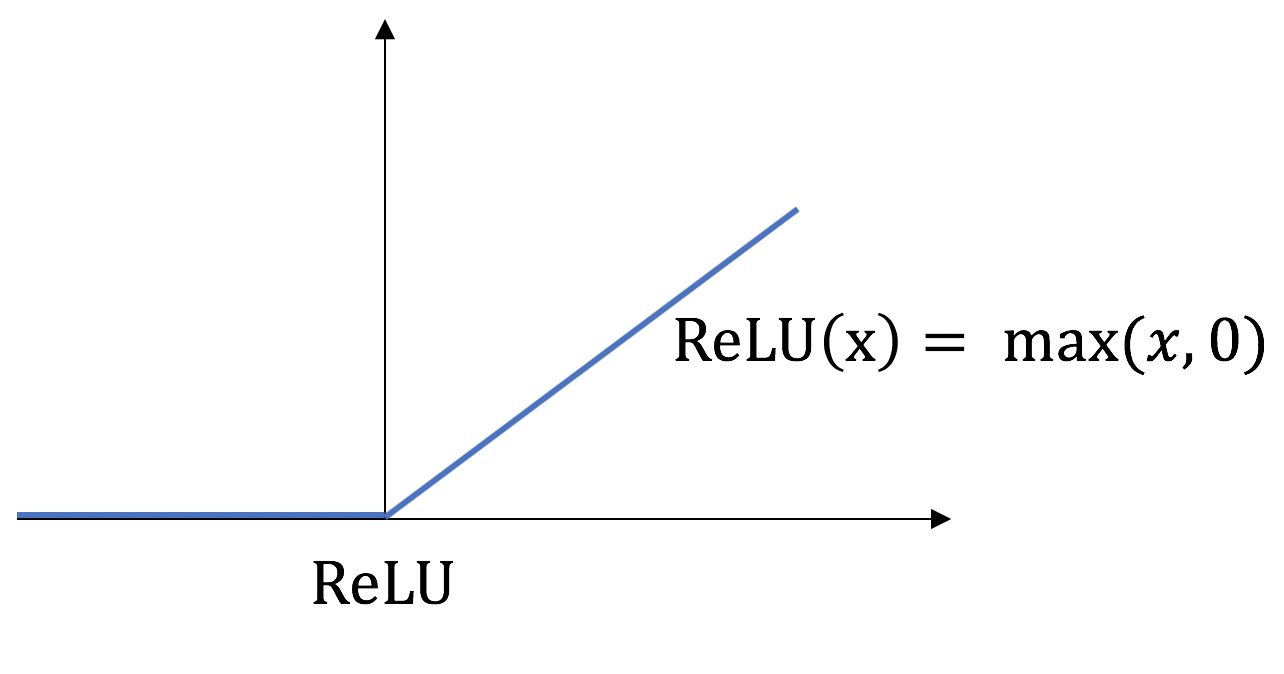

### Exercise 03
Instructions: Implement the ReLU activation function below. Your function should take in a matrix or vector and it should transform all the negative numbers into 0 while keeping all the positive numbers intact.

Please use numpy.maximum(A,k) to find the maximum between each element in A and a scalar k

In [19]:
# I want a layer because later I will differentiate it. I can't do that automatically with a function

class RELU(Layer):
    def forward(self, x):
      activation = np.maximum(0, x)
      return activation

In [20]:
x = np.array([[-2.0, -1.0, 0.0], [0.0, 1.0, 2.0]], dtype=float)

test_relu = RELU() # Instantiate, then apply x

print(test_relu(x))

[[0. 0. 0.]
 [0. 1. 2.]]


## 3.2 Dense class
### Exercise
Implement the forward function of the Dense class.

The forward function multiplies the input to the layer (x) by the weight matrix (W)

You can use numpy.dot to perform the matrix multiplication.
* Note that for more efficient code execution, you will use the trax version of math, which includes a trax version of numpy and also random.

Implement the weight initializer new_weights function

* Weights are initialized with a random key.
* The second parameter is a tuple for the desired shape of the weights (num_rows, num_cols)
* The num of rows for weights should equal the number of columns in x, because for forward propagation, you will multiply x times weights.

Please use trax.fastmath.random.normal(key, shape, dtype=tf.float32) to generate random values for the weight matrix. The key difference between this function and the standard numpy randomness is the explicit use of random keys, which need to be passed. While it can look tedious at the first sight to pass the random key everywhere, you will learn in Course 4 why this is very helpful when implementing some advanced models.

* key can be generated by calling random.get_prng(seed=) and passing in a number for the seed.
* shape is a tuple with the desired shape of the weight matrix.
  * The number of rows in the weight matrix should equal the number of columns in the variable x. Since x may have 2 dimensions if it reprsents a single training example (row, col), or three dimensions (batch_size, row, col), get the last dimension from the tuple that holds the dimensions of x.
  * The number of columns in the weight matrix is the number of units chosen for that dense layer. Look at the __init__ function to see which variable stores the number of units.
* dtype is the data type of the values in the generated matrix; keep the default of tf.float32. In this case, don't explicitly set the dtype (just let it use the default value).

Set the standard deviation of the random values to 0.1

* The values generated have a mean of 0 and standard deviation of 1.
* Set the default standard deviation stdev to be 0.1 by multiplying the standard deviation to each of the values in the weight matrix.

In [31]:
# Imported fastmath at the beginning

import trax.fastmath.numpy as np

random = fastmath.random

class Dense(Layer):
    """
    A dense (fully-connected) layer.
    """

    # __init__ is implemented for you
    def __init__(self, n_units, init_stdev=0.1):
        
        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    # Please implement 'forward()'
    def forward(self, x):

### START CODE HERE (Replace instances of 'None' with your code) ###

        # Matrix multiply x and the weight matrix
        dense = np.dot(x, self.weights) 
        
### END CODE HERE ###
        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):
        
### START CODE HERE (Replace instances of 'None' with your code) ###
        # The input_signature has a .shape attribute that gives the shape as a tuple
        input_shape = input_signature.shape

        # Generate the weight matrix from a normal distribution, 
        # and standard deviation of 'stdev'        
        # NOTICE THE _ IN _INIT_STDEV!!!
        w = self._init_stdev * random.normal(key = random_key, shape = (input_shape[-1], self._n_units))
        
### END CODE HERE ###     
        self.weights = w
        return self.weights

In [33]:
# test

dense_layer = Dense(n_units=10)  #sets  number of units in dense layer
random_key = random.get_prng(seed=0)  # sets random seed
z = np.array([[2.0, 7.0, 25.0]]) # input array 

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[-0.02837108  0.09368161 -0.10050074  0.14165013  0.105433    0.09108126
  -0.04265672  0.0986188  -0.05575325  0.00153249]
 [-0.20785688  0.0554837   0.09142365  0.05744595  0.07227863  0.01210617
  -0.03237354  0.16234994  0.02450038 -0.13809782]
 [-0.06111238  0.01403724  0.08410042 -0.1094358  -0.10775021 -0.11396459
  -0.05933381 -0.01557652 -0.03832145 -0.11144515]]
Foward function output is  [[-3.0395498   0.92668015  2.5414746  -2.050473   -1.976939   -2.582209
  -1.7952734   0.9442741  -0.8980402  -3.7497485 ]]


## 3.3 Model
Now you will implement a classifier using neural networks. Here is the model architecture you will be implementing.

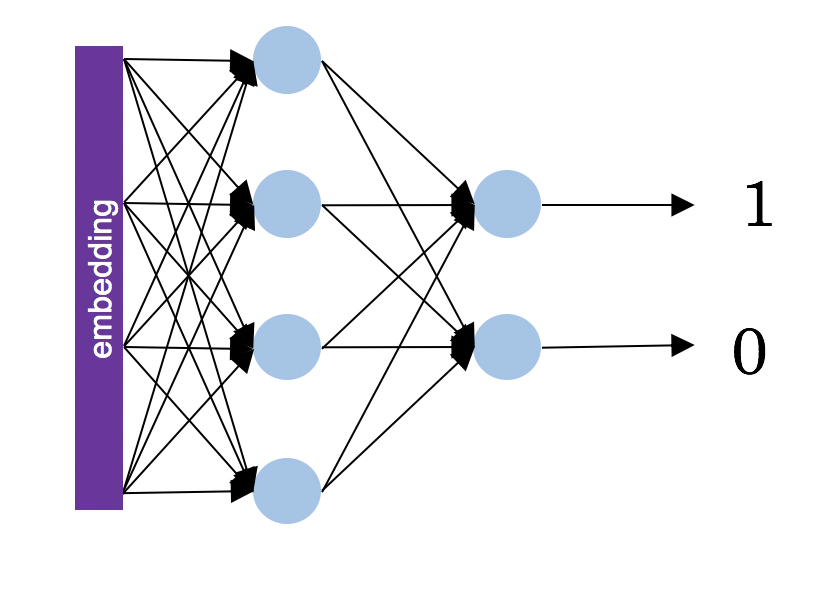

For the model implementation, you will use the Trax layers library tl. Note that the second character of tl is the lowercase of letter L, not the number 1. 

Trax layers are very similar to the ones you implemented above, but in addition to trainable weights also have a non-trainable state. State is used in layers like batch normalization and for inference, you will learn more about it in course 4.

First, look at the code of the Trax Dense layer and compare to your implementation above.

* tl.Dense: Trax Dense layer implementation

One other important layer that you will use a lot is one that allows to execute one layer after another in sequence.

* tl.Serial: Combinator that applies layers serially.
* You can pass in the layers as arguments to Serial, separated by commas.
For example: tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))